# NBAPositionify: Leveraging Data Mining Techniques to Classify Professional Basketball Players into Positions

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Get Dataset from Kaggle
# Requires the kaggle package to download dataset. Uncomment the line below to install
# !pip3 install kaggle
import kaggle
# Requires kaggle.json (Kaggle API Key) placed in ~/.kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files("drgilermo/nba-players-stats", path="./data/", unzip=True)

## Exploratory Data Analysis

Our data is from `basketball-reference.com`. Three datasets:

In [3]:
player_data = pd.read_csv("./data/player_data.csv")
player_data.head(1)

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University


In [4]:
players = pd.read_csv("./data/Players.csv")
players.head(1)

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN


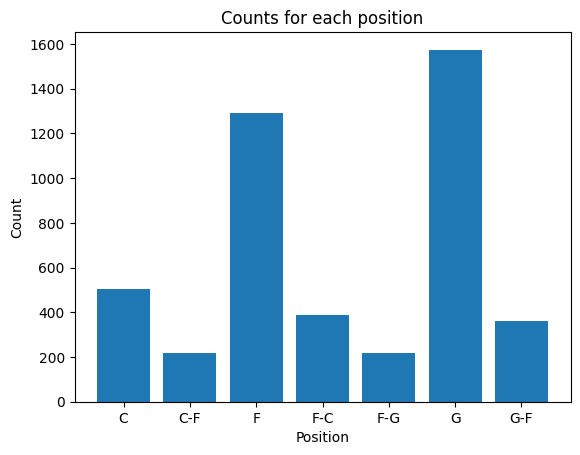

In [5]:
plt.bar(player_data.groupby('position').size().index, player_data.groupby('position').size().values)
plt.xlabel('Position')
plt.ylabel('Count')
plt.title('Counts for each position')
plt.show()

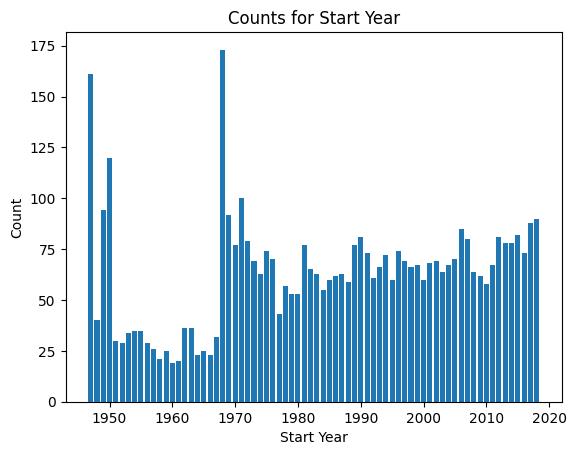

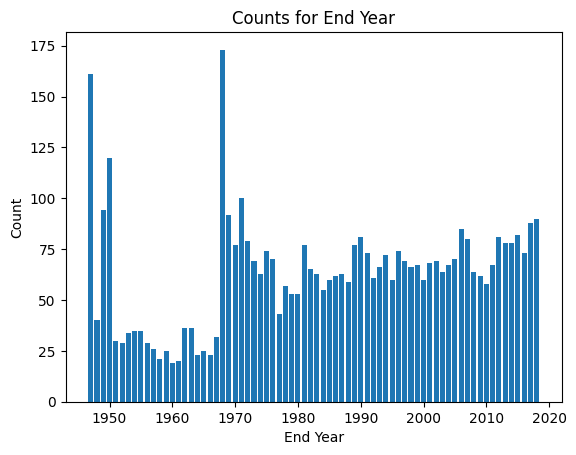

In [6]:
plt.bar(player_data.groupby('year_start').size().index, player_data.groupby('year_start').size().values)
plt.xlabel('Start Year')
plt.ylabel('Count')
plt.title('Counts for Start Year')
plt.show()

plt.bar(player_data.groupby('year_start').size().index, player_data.groupby('year_start').size().values)
plt.xlabel('End Year')
plt.ylabel('Count')
plt.title('Counts for End Year')
plt.show()

In [7]:
stats = pd.read_csv("Seasons_Stats.csv")
stats = stats.rename(columns={"Unnamed: 0" : "Index"})
# for index, row in stats.iterrows():
#     if pd.isna(row["Pos"]):
#         stats.at[index, "Pos"] = []
#     else:
#         stats.at[index, "Pos"] = row["Pos"].split("-")
stats.head()

,Index,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


# Unsupervised Naive K-Means Clustering (Points, Rebounds, Assists, Steals, Blocks)

As part of our exploratory data analysis, we did a round of naive k-means clustering, taking into account 5 stat columns which are subjectively "most relevant" to player performance and player type: points, rebounds, assists, steals and blocks. We used 5 clusters in the hopes of seeing each cluster group associated with a different position. The results yielded clusters which had datapoints evenly distributed between the 5 position classes. We hypothesized that a reason for this could be a lack of data preprocessing - some players had more stats than others, so they would be grouped in a similar class, regardless of which stats stood out. To that end, we decided to try multiple types of preprocessing on these columns - division by the number of minutes played, and normalization.

In [17]:
from sklearn.cluster import KMeans

unsupervised_kmeans_stats = stats[["PTS", "ORB", "DRB", "AST", "STL", "BLK"]].dropna()

unsupervised_kmeans_stats_1 = unsupervised_kmeans_stats.copy()
kmeans = KMeans(n_clusters=5)
kmeans.fit(unsupervised_kmeans_stats_1)

unsupervised_kmeans_stats_1["cluster"] = kmeans.labels_
unsupervised_kmeans_stats_1.insert(1, "Pos", stats["Pos"])
unsupervised_kmeans_stats_1.head()

,PTS,Pos,ORB,DRB,AST,STL,BLK,cluster
3851,865.0,C,259.0,664.0,166.0,80.0,104.0,0
3852,2191.0,C,287.0,891.0,386.0,112.0,283.0,2
3853,759.0,SF,133.0,315.0,141.0,110.0,12.0,0
3854,182.0,PG,16.0,53.0,56.0,36.0,1.0,1
3855,1268.0,PG,89.0,202.0,374.0,137.0,22.0,4


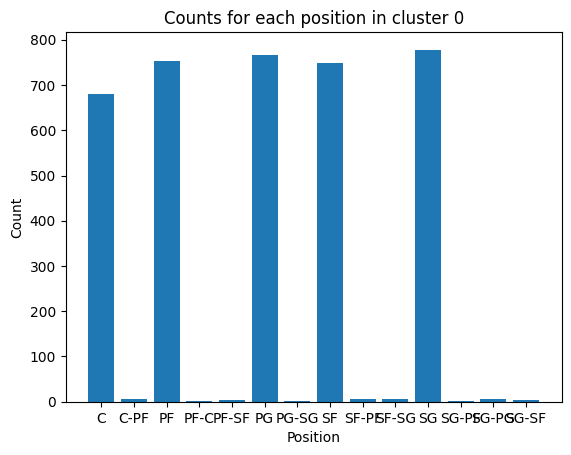

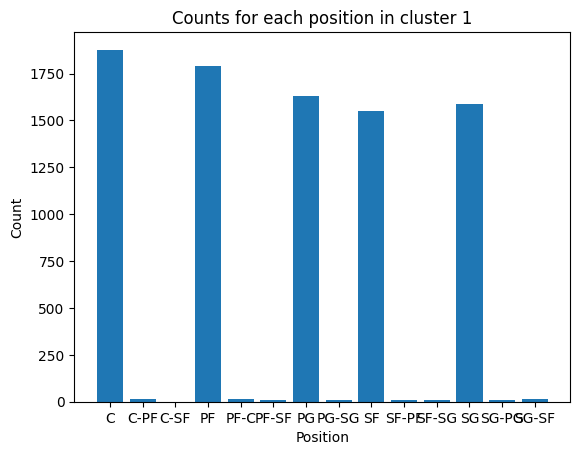

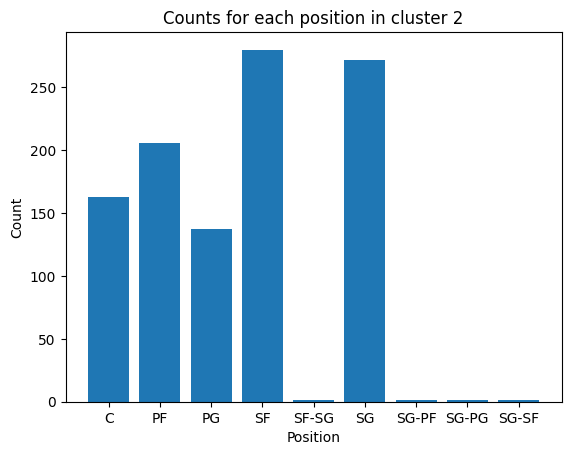

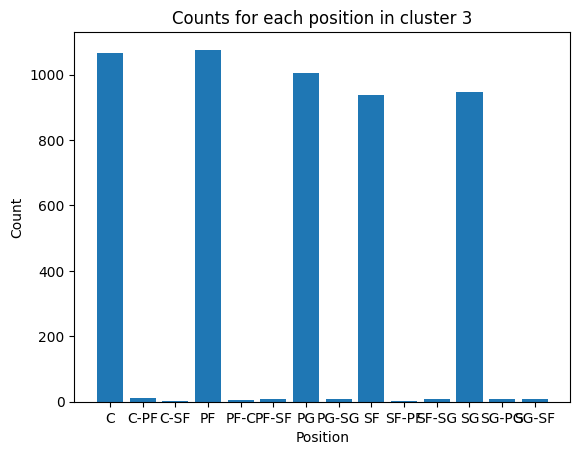

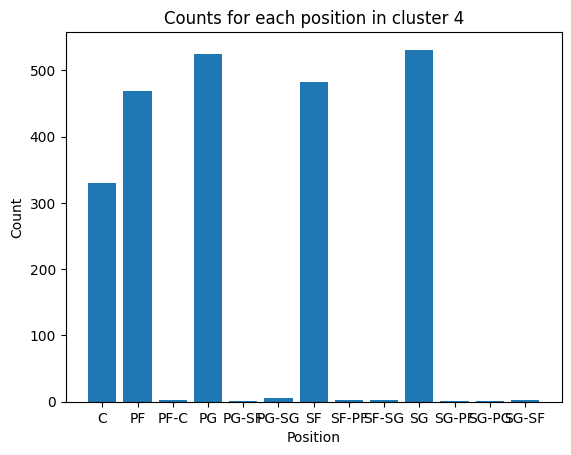

In [18]:
for cluster in range(5):
    cur_df = unsupervised_kmeans_stats_1.loc[unsupervised_kmeans_stats_1["cluster"] == cluster]
    plt.bar(cur_df.groupby('Pos').size().index, cur_df.groupby('Pos').size().values)
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.title(f'Counts for each position in cluster {cluster}')
    plt.show()

### Normalization

In [20]:
# Normalization
unsupervised_kmeans_stats_2 = (unsupervised_kmeans_stats-unsupervised_kmeans_stats.mean())/unsupervised_kmeans_stats.std()

kmeans = KMeans(n_clusters=5)
kmeans.fit(unsupervised_kmeans_stats_2)

unsupervised_kmeans_stats_2["cluster"] = kmeans.labels_
unsupervised_kmeans_stats_2.insert(1, "Pos", stats["Pos"])
unsupervised_kmeans_stats_2.head()

,PTS,Pos,ORB,DRB,AST,STL,BLK,cluster
3851,0.761684,C,2.923299,3.541624,0.386365,1.035902,2.153230,3
3852,3.500843,C,3.339193,5.097251,1.989396,1.862497,6.999571,3
3853,0.542716,SF,1.051777,1.149934,0.204203,1.810835,-0.337626,2
3854,-0.649210,PG,-0.686064,-0.645547,-0.415150,-0.100665,-0.635446,4
3855,1.594173,PG,0.398230,0.375547,1.901958,2.508274,-0.066881,1


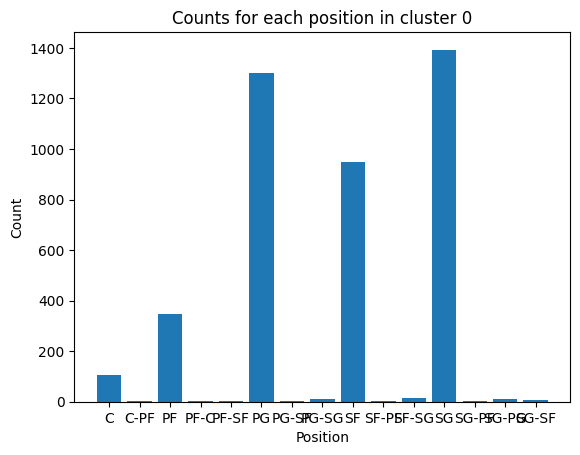

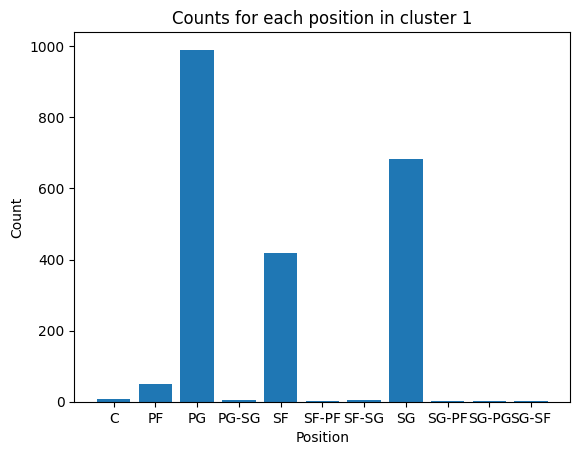

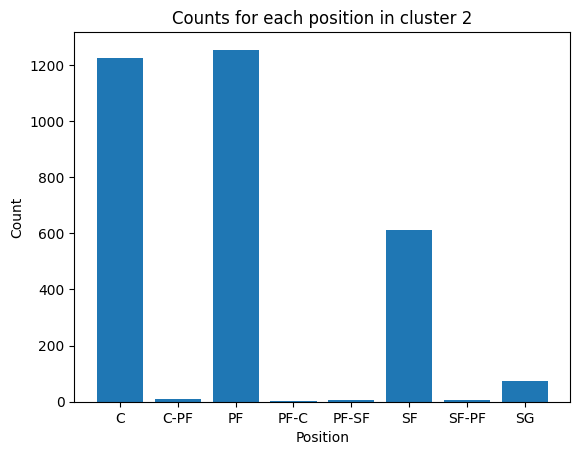

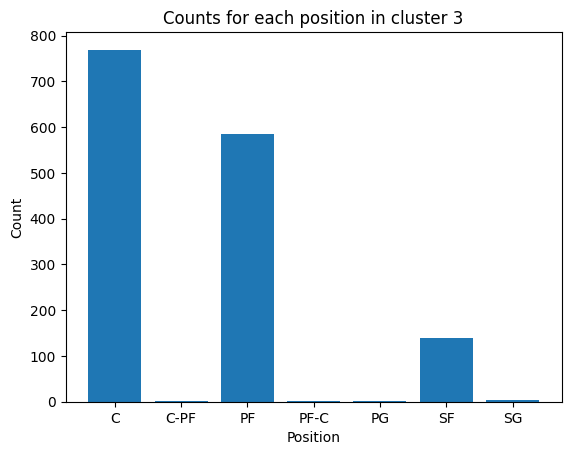

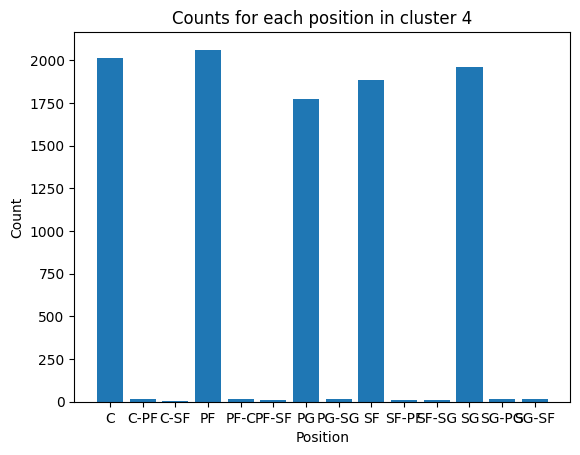

In [21]:
for cluster in range(5):
    cur_df = unsupervised_kmeans_stats_2.loc[unsupervised_kmeans_stats_2["cluster"] == cluster]
    plt.bar(cur_df.groupby('Pos').size().index, cur_df.groupby('Pos').size().values)
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.title(f'Counts for each position in cluster {cluster}')
    plt.show()

### Division by Number of Minutes

In [ ]:
# TODO: Division by number of minutes

In [11]:
for column in stats:
    print(column)

Index
Year
Player
Pos
Age
Tm
G
GS
MP
PER
TS%
3PAr
FTr
ORB%
DRB%
TRB%
AST%
STL%
BLK%
TOV%
USG%
blanl
OWS
DWS
WS
WS/48
blank2
OBPM
DBPM
BPM
VORP
FG
FGA
FG%
3P
3PA
3P%
2P
2PA
2P%
eFG%
FT
FTA
FT%
ORB
DRB
TRB
AST
STL
BLK
TOV
PF
PTS


In [12]:
# career_stats = pd.DataFrame(columns=["Years", "Player", "Pos", "Tms"])
# for player in player_rows:
#     new_row = {}
#     sub_df = stats.loc[player_rows[player]]
#     new_row["Years"] = [min(sub_df["Year"]), max(sub_df["Year"])]
#     new_row["Player"] = player
#     new_row["Pos"] = []
#     for positions in sub_df["Pos"]:
#         new_row["Pos"] += positions
#     new_row["Pos"] = list(set(new_row["Pos"]))
#     new_row["Tms"] = []
#     for team in sub_df["Tm"]:
#         if team not in new_row["Tms"]:
#             new_row["Tms"].append(team)
#     # TODO: Get summary of all other columns in sub_df to new_row
#     career_stats = pd.concat([career_stats, pd.DataFrame([new_row])])
# career_stats.head()